# Bulge / Total exploration

This notebook reads in files created elsewhere containing galaxy builder models (aggregate, best individual and optimized best individual) and compares the Bulge / Total fraction to results in the literature

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import numpy as np
import pandas as pd
from copy import deepcopy
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as parsing
import gzbuilder_analysis.aggregation as aggregation
import gzbuilder_analysis.rendering as rendering
from gzbuilder_analysis.rendering.sersic import _b
import gzbuilder_analysis.fitting as fitting
from IPython.display import HTML

Read in the required files:

In [3]:
sid_list = np.loadtxt('lib/subject-id-list.csv', dtype='u8')

# catalogues to compare to
simard_df = pd.read_csv('lib/simard-catalog_fixed-n.csv', index_col=0)
simard_df_free = pd.read_csv('lib/simard-catalog_free-n.csv', index_col=0)
lackner_nb1 = pd.read_csv('lib/lackner_nb1.csv', index_col=0)
lackner_nb4 = pd.read_csv('lib/lackner_nb4.csv', index_col=0)

# GZB results
models = pd.read_pickle('lib/models.pickle')

# GZB modelling data
gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
diff_data_df = pd.read_pickle('lib/fitting_metadata.pkl')

In [4]:
catalog_results = pd.concat((
  simard_df[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt', e__B_T_r='eSbt')),
  simard_df_free[['__B_T_r', 'e__B_T_r']]
    .rename(columns=dict(__B_T_r='Sbt_free', e__B_T_r='eSbt_free')),
  lackner_nb1[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt1', BULGE_TO_TOT_R_ERR='eLbt1')),
  lackner_nb4[['BULGE_TO_TOT_R', 'BULGE_TO_TOT_R_ERR']]
    .rename(columns=dict(BULGE_TO_TOT_R='Lbt4', BULGE_TO_TOT_R_ERR='eLbt4')),
), axis=1)

display_column_map = dict(
  Sbt='Exponential + De Vaucoulers\n(Simard, 2011)',
  Sbt_free='Exponential + Sersic\n(Simard, 2011)',
  Lbt1='Exponential + Exponential\n(Lackner, 2012)',
  Lbt4='Exponential + De Vaucoulers\n(Lackner, 2012)',
)
catalog_results.rename(columns=display_column_map).describe()

,"Exponential + De Vaucoulers (Simard, 2011)",eSbt,"Exponential + Sersic (Simard, 2011)",eSbt_free,"Exponential + Exponential (Lackner, 2012)",eLbt1,"Exponential + De Vaucoulers (Lackner, 2012)",eLbt4
count,296.000000,296.000000,294.000000,294.000000,224.000000,224.000000,224.000000,224.000000
mean,0.157466,0.008885,0.292483,0.018061,0.108795,5923.105743,0.174067,0.023354
std,0.130613,0.010501,0.261888,0.031242,0.126834,51927.107199,0.174276,0.048144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000298,0.000000,0.000713
25%,0.060000,0.000000,0.090000,0.000000,0.038871,0.001090,0.045580,0.002937
50%,0.120000,0.010000,0.195000,0.010000,0.065596,0.002073,0.115510,0.007436
75%,0.220000,0.010000,0.420000,0.020000,0.127879,0.004652,0.256837,0.021660
max,0.680000,0.110000,1.000000,0.230000,0.894223,545087.000000,0.901284,0.326977


What is the relationship between measured bulge to total fraction in our different catalogues? Does it vary with the best model type calculated by Lackner & Gunn (2012) (Pure 1-component Sersic or Exponential, or either an Exponential or Pseudo-Bulge)?

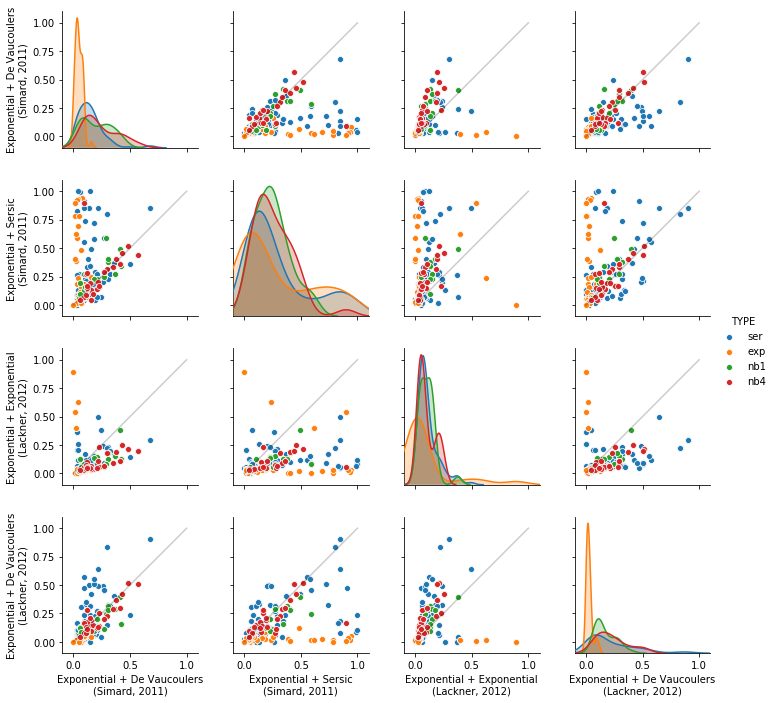

In [5]:
_df = pd.concat((
  catalog_results[['Sbt', 'Sbt_free', 'Lbt1', 'Lbt4']],
  lackner_nb1.query('TYPE != "dvc"')['TYPE'],
), axis=1).dropna()

g = sns.pairplot(
  _df.rename(columns=display_column_map),
  hue='TYPE',
)
offdiag = (ax for i, axs in enumerate(g.axes) for j, ax in enumerate(axs) if i != j)
for ax in offdiag:
  ax.add_line(plt.Line2D((0, 1), (0, 1), c='k', alpha=0.2))
  ax.set_xlim(-0.1, 1.1)
  ax.set_ylim(-0.1, 1.1)

Even when comparing the same model being fit by different surveys, we see a lot of scatter (though a notable 1:1 relationship). When Sérsic index for the bulge is fixed to 1, there is next to no agreement with other models, while a 

## Galaxy Builder measurements

We'll now introduce Galaxy Builder measurements into the mix!

First, initalise rendering Model objects for all the different kinds of model

In [6]:
def make_model(subject_id, model_dict):
    diff_data = diff_data_df.loc[subject_id]
    psf = diff_data['psf']
    data = diff_data['galaxy_data']
    sigma_image = diff_data['sigma_image']
    return fitting.Model(
        model_dict,
        data,
        psf=psf,
        sigma_image=sigma_image,
    )

In [7]:
bi_models = pd.Series([]).rename('best_individual')
with tqdm(
    models['best_individual'].dropna().items(),
    total=len(models),
    desc='[1/3] Best individual',
    leave=False,
) as bar:
    for i, model in bar:
        bi_models[i] = make_model(i, model)
      
tuned_bi_models = pd.Series([]).rename('tuned_best_individual')
with tqdm(
    models['tuned_best_individual'].dropna().items(),
    total=len(models),
    desc='[2/3] Fitted best individual',
    leave=False,
) as bar:
    for i, model in bar:
        tuned_bi_models[i] = make_model(i, model)

tuned_agg_models = pd.Series([]).rename('tuned_aggregate')
with tqdm(
    models['tuned_aggregate'].dropna().items(),
    total=len(models),
    desc='[3/3] Aggregate',
    leave=False,
) as bar:
    for i, model in bar:
        tuned_agg_models[i] = make_model(i, model)

In [8]:
columns = ('best_individual', 'tuned_best_individual', 'tuned_aggregate')
names = [
    ' '.join(map(str.capitalize, s.split('_')))
    for s in columns
]

What is the distribution of Bulge Sérsic index for our models?

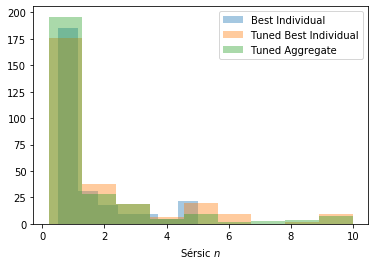

In [9]:
def get_bulge_arg(m, param='n'):
    return m['bulge'].get(param, np.nan) if m['bulge'] is not None else np.nan

for col, name in zip(
    columns,
    names,
):
    sns.distplot(
        models[col]
            .dropna()
            .apply(get_bulge_arg, param='n')
            .dropna()
            .rename(name),
        label=name,
        bins='scott',
        kde=False,
    )
plt.legend();
plt.xlabel('Sérsic $n$');

Interestingly, volunteers preferred much lower Sérsic indices than other fitting toolkits. As explored separately, this is probably to do with the allowed parameter space (dictated by the sliders and their precision) being too restricive to allow the large effective radii and low $\Sigma_e$s associated with higher Sérsic index bulges.

We would expect Galaxy Builder results to agree best with the Lackner & Gunn (2012) Exponential + Exponential model.

In [10]:
def get_measures(model):
    r = model.render()
    bulge_flux = np.zeros_like(r) + model._cache['bulge']
    bar_flux = np.zeros_like(r) + model._cache['bar']
    loss = fitting.chisq(
        r,
        model.data,
        model.sigma_image,
    )
    return pd.Series(dict(
        model_flux=r.sum(),
        gal_flux=model.data.sum(),
        bulge_flux=bulge_flux.sum(),
        bar_flux=bar_flux.sum(),
        loss=loss,
        bt=(bulge_flux + bar_flux).sum() / r.sum()
    ))

In [11]:
catalog_results['Lbt1'].dropna().sample(1).index[0]

20902054

In [12]:
# tqdm.pandas(desc='Calculating {: <25}'.format(names[0]))
bi_measures = bi_models.apply(get_measures)
# tqdm.pandas(desc='Calculating {: <25}'.format(names[1]))
tuned_measures = tuned_bi_models.apply(get_measures)
# tqdm.pandas(desc='Calculating {: <25}'.format(names[2]))
tuned_agg_measures = tuned_agg_models.apply(get_measures)

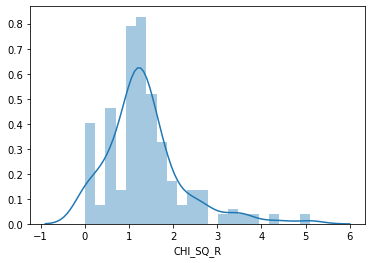

In [13]:
sns.distplot(lackner_nb1['CHI_SQ_R'])

ValueError: output array is read-only

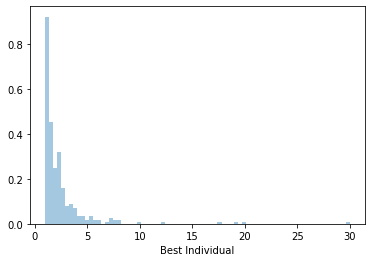

In [14]:
for i, measure in enumerate((tuned_measures, tuned_agg_measures)):
  sns.distplot(measure.loss.dropna().rename(names[i]), kde=False, bins='auto', norm_hist=True)
sns.distplot(lackner_nb4['CHI_SQ_R'], kde=False, norm_hist=True)
plt.xlim(0, 15)
plt.xlabel(r'$\chi_\nu^2$');

ValueError: cannot convert float NaN to integer

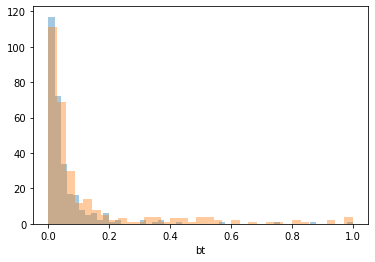

In [15]:
sns.distplot(bi_measures['bt'], kde=False)
sns.distplot(tuned_measures['bt'], kde=False)
sns.distplot(tuned_agg_measures['bt'], kde=False)
sns.distplot(catalog_results['Lbt1'].dropna(), kde=False)
sns.distplot(catalog_results['Lbt4'].dropna(), kde=False)
plt.xlabel(r'$(B/T)_r$')

## Results

Make Series of bulge/total and bar/total ratios

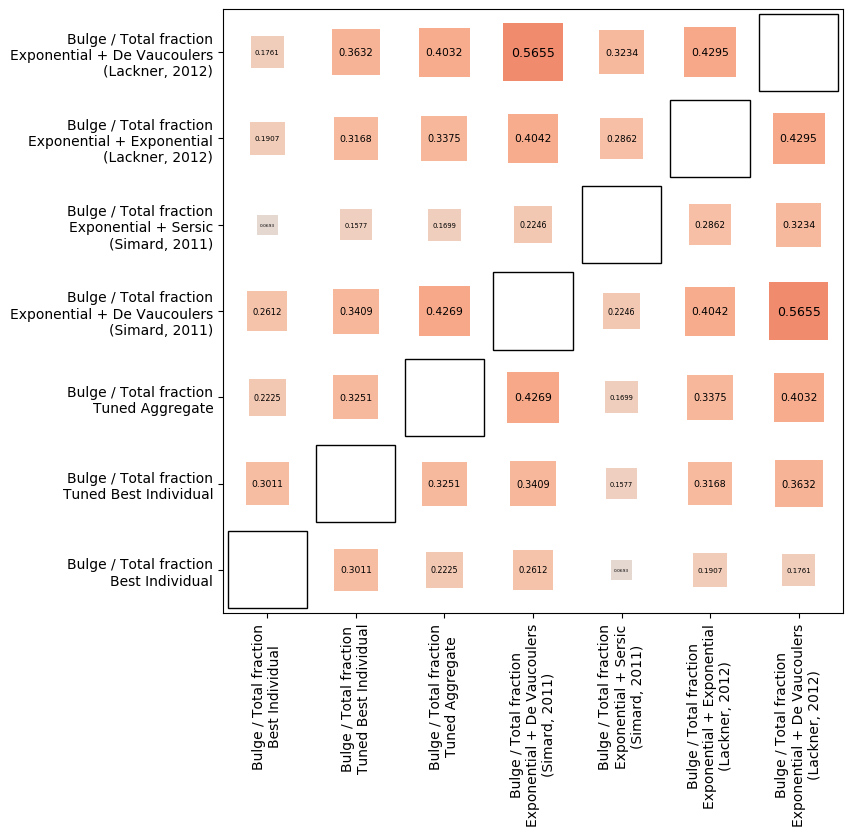

In [16]:
_df2 = pd.concat((
  bi_measures['bt'].rename(names[0]),
  tuned_measures['bt'].rename(names[1]),
  tuned_agg_measures['bt'].rename(names[2]),
  catalog_results[display_column_map.keys()].rename(columns=display_column_map),
), axis=1)
plt.figure(figsize=(8, 8), dpi=100)
correlation = _df2.corr(method='kendall').values
scale = 0.8
for i in range(correlation.shape[0]):
  for j in range(correlation.shape[1]):
    if i == j:
      fc = 'none'
      ec = 'k'
    else:
      fc = plt.cm.coolwarm((correlation[i, j] + 1) / 2)
      ec = 'none'
    rect_size = np.sqrt(correlation[i, j] * scale)
    centre = i - rect_size / 2, j - rect_size/2
    s = plt.Rectangle(
      centre, width=rect_size, height=rect_size,
      fc=fc, ec=ec
    )
    plt.gca().add_patch(s)
    if i != j:
      t = plt.text(
        i, j,
        '{:.4f}'.format(correlation[i, j]),
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12 * np.sqrt(correlation[i, j])
      )
cols = ['Bulge / Total fraction\n' + i for i in _df2.columns]
plt.xticks(np.arange(7), cols, rotation=90)
plt.xlim(-0.5, 6.5)
plt.yticks(np.arange(7), cols)
plt.ylim(-0.5, 6.5)
plt.savefig('method-paper-plots/b-t_comparison_correlation.pdf', bbox_inches='tight');

We see that Galaxy Builder results correlate as well with other catalogues as the catalogues with each other (when not comparing identical models). But this tells us nothing of whether this correlation is 1:1 - for that we need to look at the point scatter:

As the Exp + Sersic model was all over the place, we ignore it in the following plot

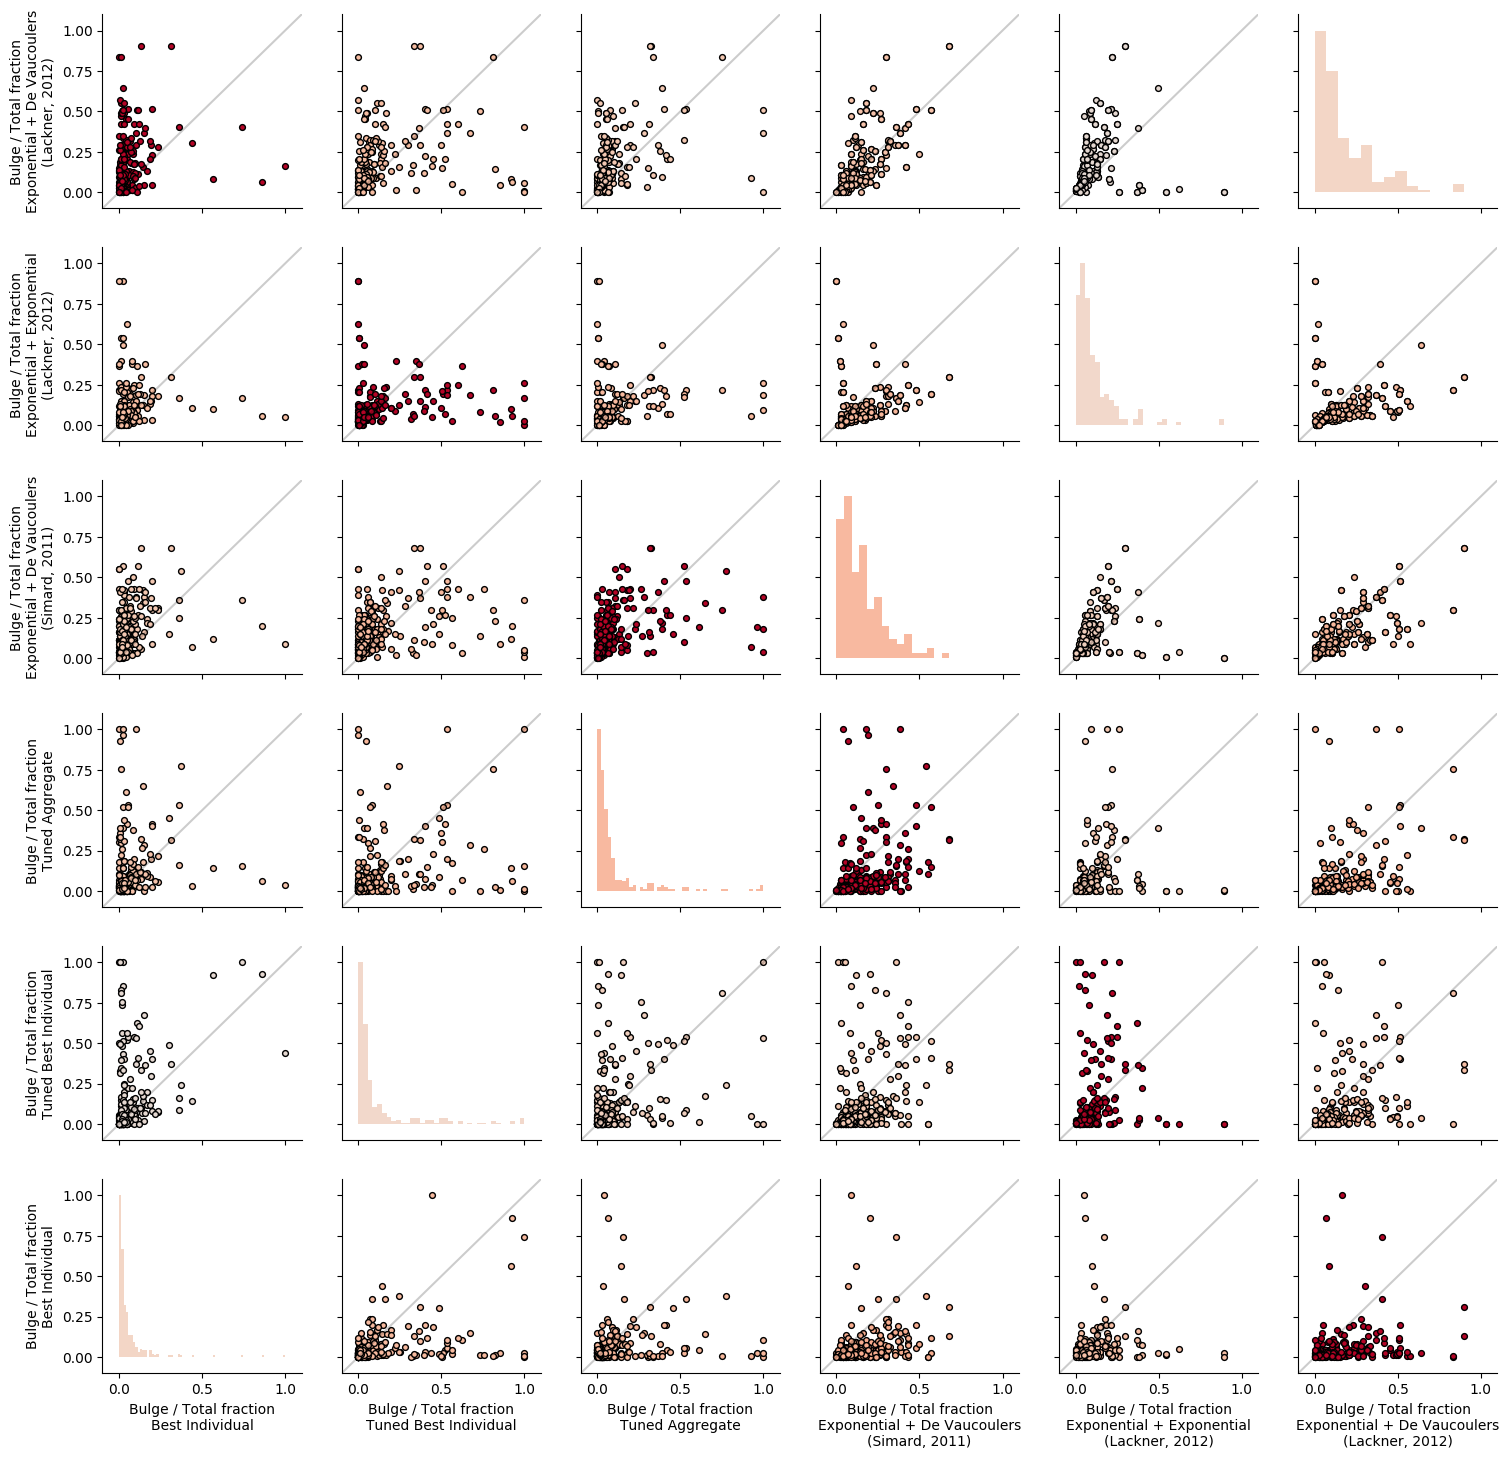

In [25]:
xcols = _df2.columns[[0, 1, 2, 3, 5, 6]]
# flip y so we preserve the same positions as above
ycols = cols[::-1]
marker_kws = dict(s=17.5, edgecolors='k')
f, axs = plt.subplots(ncols=len(xcols), nrows=len(ycols), figsize=(18, 18), dpi=100, sharex=True, sharey=True)
for i in range(len(ycols)):
  for j in range(len(xcols)):
    fc = np.array(plt.cm.coolwarm((correlation[i, j] + 1) / 2))
    if ycols[i] == xcols[j]:
      hist, edges = np.histogram(_df2[ycols[i]].dropna(), density=True, bins='auto')
      for k in range(len(edges) - 1):
        axs[i][j].add_patch(
          plt.Rectangle(
            (edges[k], 0),
            width=edges[k+1] - edges[k],
            height=hist[k] / hist.max(),
            fc=fc,
            alpha=0.8,
          )
        )
    else:
      _d = _df2[[ycols[i], xcols[j]]].dropna()
      axs[i][j].scatter(_d[xcols[j]], _d[ycols[i]], c=fc[np.newaxis, :], **marker_kws)
      axs[i][j].add_line(plt.Line2D((-1.5, 1.5), (-1.5, 1.5), c='k', alpha=0.2))
    axs[i][j].set_xlim(-0.1, 1.1)
    axs[i][j].set_ylim(-0.1, 1.1)
    if j == 0:
      axs[i][j].set_ylabel('Bulge / Total fraction\n' + ycols[i])
    if i == len(cols) - 1:
      axs[i][j].set_xlabel('Bulge / Total fraction\n' + xcols[j])
sns.despine()
plt.savefig('method-paper-plots/b-t_comparison_scatter.pdf', bbox_inches='tight');

We see that there is only really a 1:1 relationship between galaxy builder results and the Lackner & Gunn (2012) Exponential + Exponential model, suggesting that the bias present in Galaxy Builder Bulge Sérsic indices plays a huge part in the calculation of Bulge / Total ratio.

We see similar relationships when comparing between different bulge + disk models (i.e. exp + exp to exp + dv) as we do when comparing the more complex galaxy builder models, suggesting that it is the bulge sersic index which is causing the systematic difference.